# Q-learning notebook

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment import WrappedEnvironment, Actions, CONTEXTS_LABELS
from agent import Qlearning, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=3, numEpisodes=100)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.05, jointRep=True, n_runs=3, numEpisodes=100)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

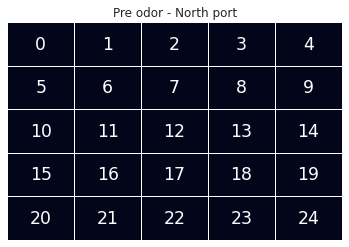

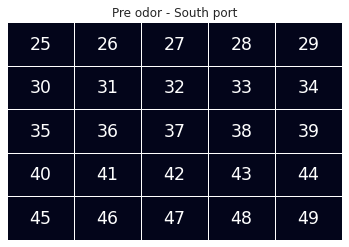

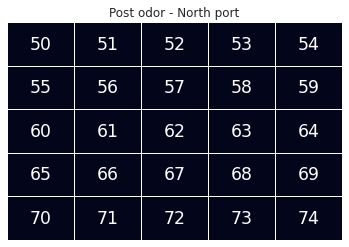

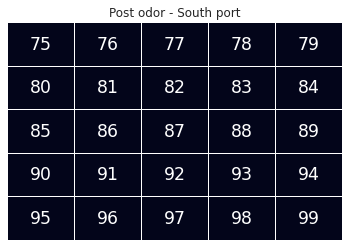

In [6]:
# State space
for idx, label in enumerate(CONTEXTS_LABELS):
    plotting.plot_tiles_locations(
        np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations),
        env.rows,
        env.cols,
        title=label,
    )

In [7]:
# Load the agent algorithms
learner = Qlearning(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

## Main loop

In [8]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, env.numStates, env.numActions))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity

    learner.reset_qtable()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.qtable[state, action] = learner.update(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.qtable

## Postprocessing

In [9]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [10]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,0.0,100.0,0.0
1,1,0.0,27.0,10.0
2,2,0.0,177.0,20.0
3,3,10.0,98.0,30.0
4,4,0.0,30.0,40.0
...,...,...,...,...
295,95,10.0,6.0,910.0
296,96,10.0,8.0,920.0
297,97,10.0,14.0,930.0
298,98,10.0,8.0,940.0


In [11]:
# plotting.qtable_directions_map(qtable, env.rows, env.cols)

## Visualization

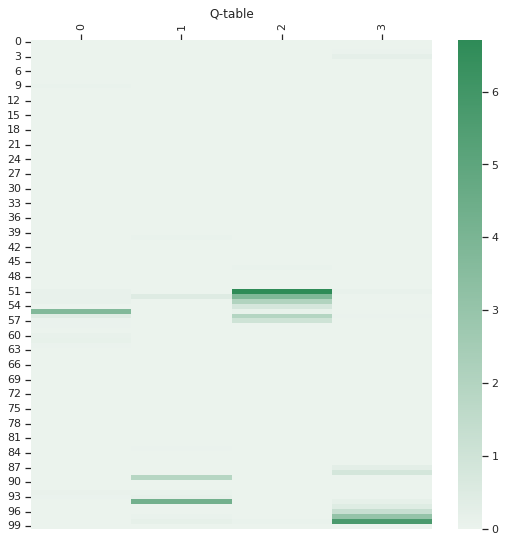

In [12]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

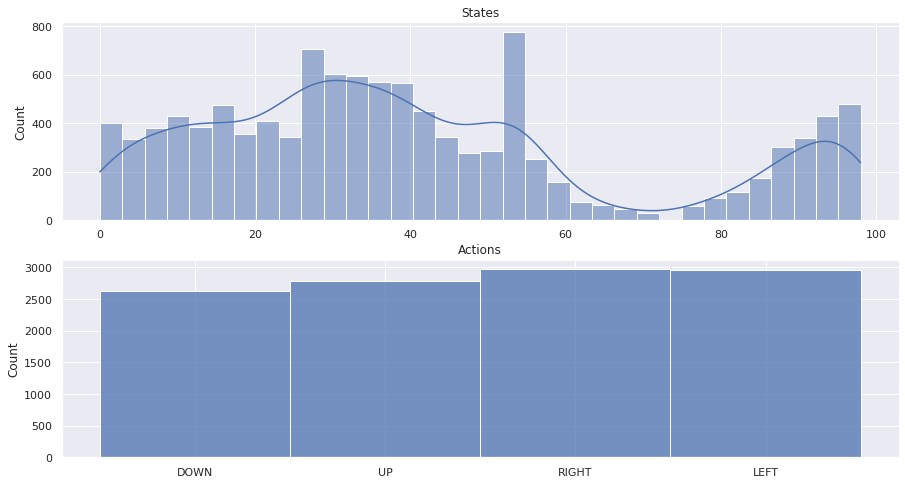

In [13]:
plotting.plot_states_actions_distribution(all_states, all_actions)

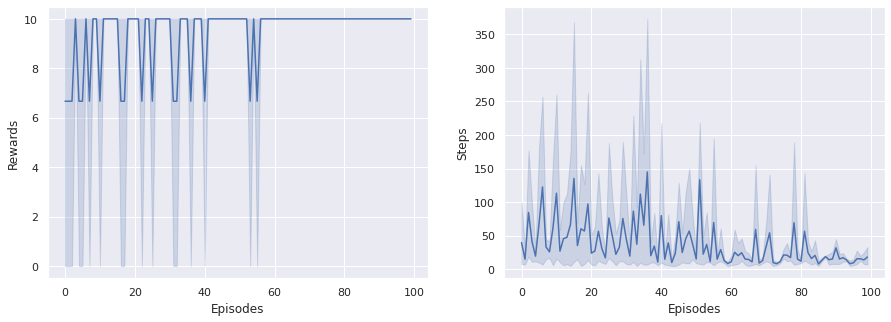

In [14]:
plotting.plot_steps_and_rewards(res)

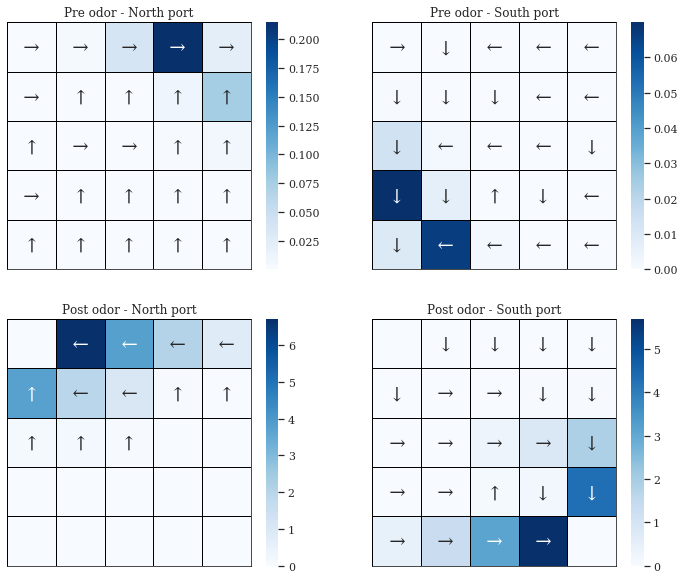

In [15]:
plotting.plot_q_values_maps(qtable, env.rows, env.cols)

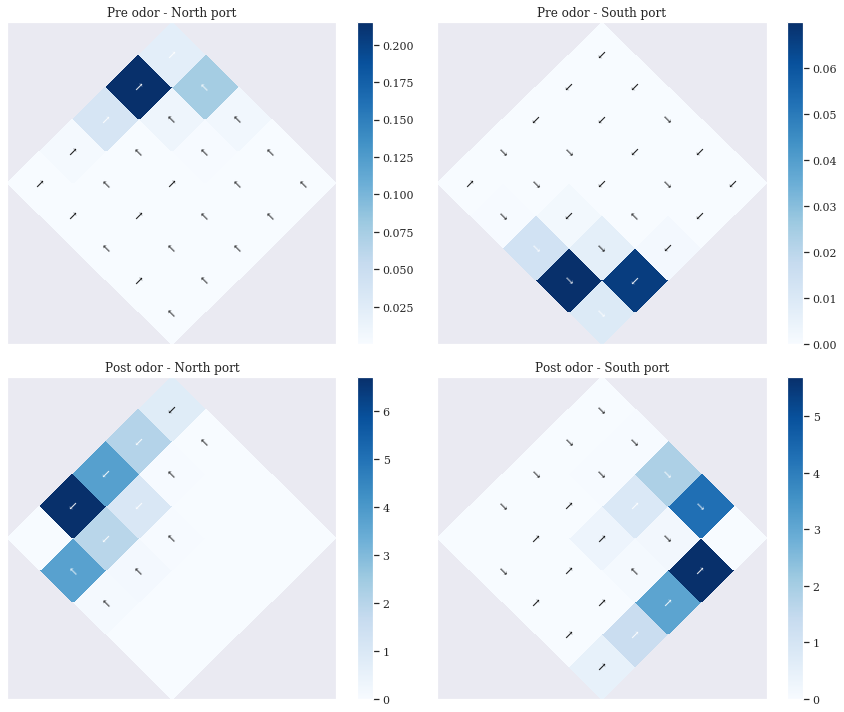

In [16]:
plotting.plot_rotated_q_values_maps(qtable, env.rows, env.cols)